Feature selection using SelectFromModel with RidgeCV and LassoCV

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LassoCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [ ]:
###########################
# In this notebook, we experiment with two different ways of selecting features for a model, and use it to learn the difference between the German and Spanish leagues.
###########################

In [112]:
all_shots = pd.read_csv("./data/augmented_data.csv")
laliga_shots = pd.read_csv("./data/laliga_shots.csv")
bundesliga_shots = pd.read_csv("./data/bundesliga_shots.csv")

In [113]:
all_leagues = [all_shots, laliga_shots, bundesliga_shots]

for league in all_leagues:
    league.drop(['period', 'minute', 'possession', 'duration', 'season_id', 'match_id', 'timestamp', 'team'], axis=1, inplace=True)
    # drop redundant features
    league.drop(["location_x", "location_y"], axis=1, inplace=True)
    # drop features that leak target information
    league.drop(["shot_angle"], axis=1, inplace=True)
    # drop low information features
    league.drop(["aerial_won", "follows_dribble", "num_passes", "pass_duration", "pass_height", "pass_type", "type"], axis=1, inplace=True)
    # "position", "body_part", "type", "pass_height", "pass_type"

In [114]:
encoded_data = all_shots
for column_name in ["technique", "body_part", "play_pattern", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
all_shots = encoded_data

all_shots = all_shots.dropna()
all_shots.replace([np.inf, -np.inf], 0, inplace=True)

encoded_data = laliga_shots
for column_name in ["technique", "body_part", "play_pattern", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
laliga_shots = encoded_data

laliga_shots = all_shots.dropna()
laliga_shots.replace([np.inf, -np.inf], 0, inplace=True)

encoded_data = bundesliga_shots
for column_name in ["technique", "body_part", "play_pattern", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
bundesliga_shots = encoded_data

bundesliga_shots = bundesliga_shots.dropna()
bundesliga_shots.replace([np.inf, -np.inf], 0, inplace=True)



In [139]:
all_shots_y1 = all_shots["statsbomb_xg"]
all_shots_y2 = all_shots["is_goal"]
all_shots_X = all_shots.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

laliga_y1 =laliga_shots["statsbomb_xg"]
laliga_y2 =laliga_shots["is_goal"]
laliga_X = laliga_shots.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

bundesliga_y1 = bundesliga_shots["statsbomb_xg"]
bundesliga_y2 = bundesliga_shots["is_goal"]
bundesliga_X =  bundesliga_shots.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

In [140]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    
    return f1

In [141]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    f1 = calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test), f1

In [151]:
def decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=50, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    f1 = calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [143]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.10, max_depth=12, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)
    
    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [144]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.3).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [145]:
bundesliga_X_train, bundesliga_X_test, bundesliga_y_train, bundesliga_y_test = preprocess_classifier(bundesliga_X, bundesliga_y2)
laliga_X_train, laliga_X_test, laliga_y_train, laliga_y_test = preprocess_classifier(laliga_X, laliga_y2)
all_shots_X_train, all_shots_X_test, all_shots_y_train, all_shots_y_test = preprocess_classifier(all_shots_X, all_shots_y2)

In [182]:
# SFM with LassoCV for all leagues

lasso_cv = LassoCV(cv=5) 
lasso_cv.fit(bundesliga_X_train, bundesliga_y_train) 

LassoCV(cv=5)

In [184]:
coefs = pd.DataFrame(lasso_cv.coef_, index=bundesliga_X.columns, columns=["coef"])
coefs.sort_values(by="coef", ascending=False, inplace=True)
coefs[:15]

,coef
shooting_range,0.135300
goalkeeper_y,0.022982
technique_Normal,0.021875
play_pattern_From Counter,0.020727
technique_Lob,0.017051
position_Left Attacking Midfield,0.011474
open_goal,0.010350
position_Left Wing,0.010242
game_state,0.009125
pass_length,0.008474


In [185]:
sfm_lcv = SelectFromModel(estimator = lasso_cv, prefit=True, max_features=15)

train_selected_lcv = sfm_lcv.transform(bundesliga_X_train)

test_selected_lcv = sfm_lcv.transform(bundesliga_X_test)

# replace sfm_lcv with sfm to test features selected by SFM w/ ridge regression
df_lcv = pd.DataFrame(sfm_lcv.get_support(), bundesliga_X.columns, columns=["Selected"])

selected_bundesliga = []
for column in df_lcv[df_lcv["Selected"] == True].index:
    selected_bundesliga.append(column)

In [181]:
# These are the features selected overall
selected_all

['location_y_distance',
 'open_goal',
 'one_on_one',
 'defenders_3m_radius',
 'defenders_triangle',
 'goalkeeper_x',
 'distance_to_goalie',
 'shooting_range',
 'shots_so_far',
 'game_state',
 'technique_Backheel',
 'technique_Diving Header',
 'technique_Lob',
 'technique_Normal',
 'body_part_Head']

In [186]:
# These are the features selected when we trained only on the Bundesliga
selected_bundesliga

['is_penalty',
 'defenders_3m_radius',
 'defenders_triangle',
 'goalkeeper_x',
 'goalkeeper_y',
 'distance_to_goalie',
 'shooting_range',
 'goal_distance',
 'technique_Lob',
 'technique_Normal',
 'body_part_Head',
 'body_part_Other',
 'play_pattern_From Corner',
 'play_pattern_From Counter',
 'play_pattern_Other']

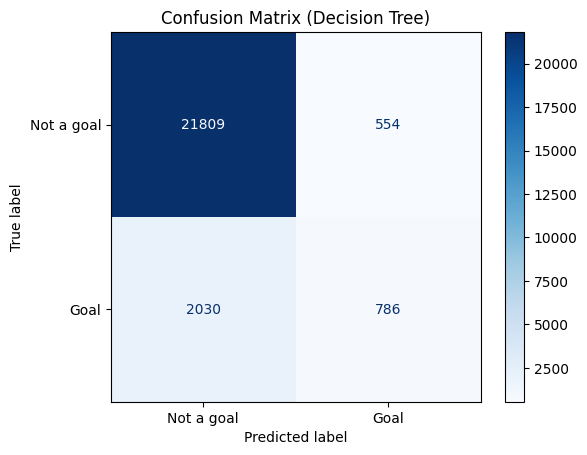


Decision Tree
Accuracy: 0.8973747964573653
Precision: 0.5865671641791045
Recall: 0.2791193181818182
F1: 0.3782483156881617


In [162]:
dt_xg, viz = decision_tree(train_selected_lcv, all_shots_y_train, test_selected_lcv, all_shots_y_test)

In [132]:
selected

['one_on_one',
 'defenders_3m_radius',
 'defenders_triangle',
 'goalkeeper_x',
 'distance_to_goalie',
 'shooting_range',
 'game_state',
 'technique_Lob',
 'technique_Normal',
 'body_part_Head']